# TCP movements and Weaving - Saving plots

This notebook demonstrates the fellowing topics:

* save your matplotlib figures as PNG file
* write to an in memory buffer
* encode with base64
* display it as HTML image tag

See the original tutorial at: https://weldx.readthedocs.io/en/latest/tutorials/welding_example_02_weaving.html

In [1]:
# some python imports that will be used throughout the tutorial
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pint
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# importing the weldx package with prevalent default abbreviations
import weldx
import weldx.geometry as geo
import weldx.transformations as tf
from weldx import util
import weldx.visualization as vis
from weldx import Q_
from weldx.core import MathematicalExpression, TimeSeries
from weldx.transformations import LocalCoordinateSystem as lcs
from weldx.transformations import WXRotation

In [3]:
from weldx.welding.groove.iso_9692_1 import get_groove

groove = get_groove(
    groove_type="VGroove",
    workpiece_thickness=Q_(0.5, "cm"),
    groove_angle=Q_(50, "deg"),
    root_face=Q_(1, "mm"),
    root_gap=Q_(1, "mm"),
)

In [4]:
# define the weld seam length in mm
seam_length = 150

# create a linear trace segment a the complete weld seam trace
trace_segment = geo.LinearHorizontalTraceSegment(seam_length)
trace = geo.Trace(trace_segment)

# create 3d workpiece geometry from the groove profile and trace objects
geometry = geo.Geometry(groove.to_profile(width_default=Q_(5, "mm")), trace)

# rasterize geometry
profile_raster_width = 2  # resolution of each profile in mm
trace_raster_width = 30  # space between profiles in mm
geometry_data_sp = geometry.rasterize(
    profile_raster_width=profile_raster_width, trace_raster_width=trace_raster_width
)

In [5]:
# crete a new coordinate system manager with default base coordinate system
csm = weldx.transformations.CoordinateSystemManager("base")

# add the workpiece coordinate system
csm.add_cs(
    coordinate_system_name="workpiece",
    reference_system_name="base",
    lcs=trace.coordinate_system,
)

# add the geometry data of the specimen
csm.assign_data(
    geometry.spatial_data(profile_raster_width, trace_raster_width),
    "specimen",
    "workpiece",
)

In [6]:
tcp_start_point = Q_([5.0, 0.0, 2.0], "mm")
tcp_end_point = Q_([seam_length - 5.0, 0.0, 2.0], "mm")

v_weld = Q_(10, "mm/s")
s_weld = (tcp_end_point - tcp_start_point)[0]  # length of the weld
t_weld = s_weld / v_weld

t_start = pd.Timedelta("0s")
t_end = pd.Timedelta(str(t_weld))

rot = WXRotation.from_euler("x", 180, degrees=True)

coords = [tcp_start_point.magnitude, tcp_end_point.magnitude]

tcp_wire = lcs(coordinates=coords, orientation=rot, time=[t_start, t_end])

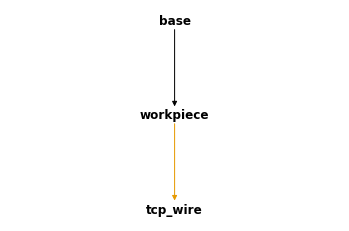

In [7]:
csm.add_cs(
    coordinate_system_name="tcp_wire", reference_system_name="workpiece", lcs=tcp_wire
)
csm

In [8]:
def ax_setup(ax, rotate=170):
    ax.legend()
    ax.set_xlabel("x / mm")
    ax.set_ylabel("y / mm")
    ax.set_zlabel("z / mm")
    ax.view_init(30, -10)
    ax.set_ylim([-5.5, 5.5])
    ax.view_init(30, rotate)
    ax.legend()


color_dict = {
    "tcp_sine": (255, 0, 0),
    "tcp_wire_sine": (255, 0, 0),
    "tcp_wire_sine2": (255, 0, 0),
    "tcp_wire": (0, 150, 0),
    "specimen": (0, 0, 255),
}

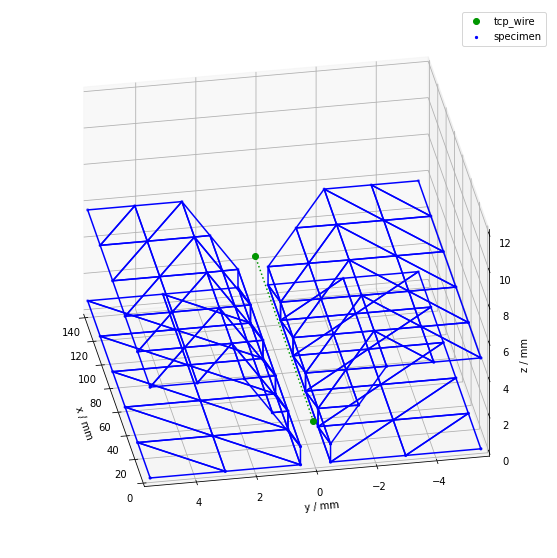

In [9]:
ax = csm.plot(
    coordinate_systems=["tcp_wire"],
    colors=color_dict,
    limits=[(0, 140), (-5, 5), (0, 12)],
    show_vectors=False,
    show_wireframe=True,
)
ax_setup(ax)

In [10]:
# save your plot as an image 
with open("plot.png", "wb") as plot_file:
        fig = ax.get_figure()
        fig.savefig(plot_file, bbox_inches="tight")

In [11]:
# save it as in memory buffer ...
import io

buffer = io.BytesIO()
fig = ax.get_figure()
fig.savefig(buffer, bbox_inches="tight")

In [12]:
# ... and encode it as base64 string
import base64

base64_string = base64.b64encode(buffer.getvalue()).decode()


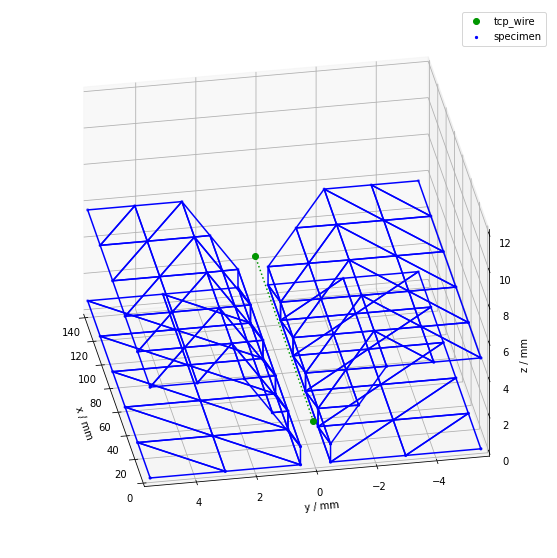

In [13]:
# just believe what you saw for yourself 
from IPython.display import HTML, display
html_img = "<img src='data:image/png;base64,{0}' width='500' />".format(base64_string)
display(HTML(html_img))